In [1]:
# Header for the notebook
from datetime import datetime
from IPython.display import display, Markdown

# Get the current date
title = "Template for a Jupyter Notebook"
current_date = datetime.now().strftime("%d %B %Y, %H:%M:%S")
authors = "Théo Lecomte , Baptiste Augros and Camille Jaffeux"

# Insert the date into the notebook
display(Markdown(f"# {title}"))
display(Markdown(f"{current_date}"))
display(Markdown(f"by {authors}"))

# Template for a Jupyter Notebook

21 November 2025, 11:51:18

by Théo Lecomte , Baptiste Augros and Camille Jaffeux

# MouseReCo

In [2]:
# imports (this is all you need for this assignment - please, do not import anything else)
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import datetime
# very useful for zoomable plots in Jupyter notebooks
%matplotlib widget

# import pandas as pd # we do not use pandas here

In [3]:
# if the present working directory is the directory of this file, change the path to the project root
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

## Défnir les intervals

In [4]:
#load csv data
file_path = "data/001MoDe_R1.marker.csv"

# 🔹 Lecture du fichier brut (toutes les lignes)
with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# 🔹 On garde uniquement les lignes correspondant aux logs DoCycleChange
log_lines = [line.strip() for line in lines if "DoCycleChange" in line or "DoRecord" in line or "DoPause" in line]
# 🔹 Transformation en DataFrame (on split seulement les 3 premières valeurs)
df = pd.DataFrame([line.split(",", 2) for line in log_lines],
                  columns=["timestamp", "ms", "event"])

# 🔹 Conversion du timestamp en datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

#print(df.head())

#if you want to extract specific events, e.g., "DoRecord" and "DoPause":
do_record_times = df[df["event"].str.contains("DoRecord", na=False)]["timestamp"]
do_pause_times = df[df["event"].str.contains("DoPause", na=False)]["timestamp"]
print("DoRecord timestamps:")
print(do_record_times)
print("DoPause timestamps:")
print(do_pause_times)

#Afficher les temps pour le 1er "DoRecord" et le 1er "DoPause"
print("First DoRecord timestamp:", do_record_times.iloc[0] if not do_record_times.empty else "Not found")
print("First DoPause timestamp:", do_pause_times.iloc[0] if not do_pause_times.empty else "Not found")

#Fonction to extract intervals between "DoRecord" and "DoPause"
def extract_record_pause_intervals(df):
    record_times = df[df["event"].str.contains("DoRecord", na=False)]["ms"].reset_index(drop=True)
    pause_times  = df[df["event"].str.contains("DoPause",  na=False)]["ms"].reset_index(drop=True)

    intervals = []
    min_length = min(len(record_times), len(pause_times))

    for i in range(min_length):
        start_ms = int(record_times.iloc[i])
        end_ms   = int(pause_times.iloc[i])
        duration = (end_ms - start_ms) / 1000.0  # secondes

        intervals.append((start_ms, end_ms, duration))

    return intervals
intervals = extract_record_pause_intervals(df)
print("Record-Pause Intervals:")
for i, (start, end, duration) in enumerate(intervals):
    #Print Interval 1,2,..
    print(f"Interval {i+1}: Start - {start}, End - {end}, Duration - {duration:.3f} seconds")

DoRecord timestamps:
2    2021-03-26 17:38:32.333
4    2021-03-26 17:39:12.340
6    2021-03-26 17:39:52.372
8    2021-03-26 17:40:32.390
10   2021-03-26 17:41:12.419
Name: timestamp, dtype: datetime64[ns]
DoPause timestamps:
3    2021-03-26 17:38:52.336
5    2021-03-26 17:39:32.351
7    2021-03-26 17:40:12.386
9    2021-03-26 17:40:52.404
11   2021-03-26 17:41:32.433
Name: timestamp, dtype: datetime64[ns]
First DoRecord timestamp: 2021-03-26 17:38:32.333000
First DoPause timestamp: 2021-03-26 17:38:52.336000
Record-Pause Intervals:
Interval 1: Start - 1616776712333, End - 1616776732336, Duration - 20.003 seconds
Interval 2: Start - 1616776752340, End - 1616776772351, Duration - 20.011 seconds
Interval 3: Start - 1616776792372, End - 1616776812386, Duration - 20.014 seconds
Interval 4: Start - 1616776832390, End - 1616776852404, Duration - 20.014 seconds
Interval 5: Start - 1616776872419, End - 1616776892433, Duration - 20.014 seconds


                timestamp             ms  \
0 2021-03-26 17:38:32.325  1616776712325   
1 2021-03-26 17:38:32.331  1616776712331   
2 2021-03-26 17:38:32.333  1616776712333   
3 2021-03-26 17:38:52.336  1616776732336   
4 2021-03-26 17:39:12.340  1616776752340   

                                               event  
0                          KeyTyped=32 DoCycleChange  
1            DoCycleChange:DoStartCycleTimedSequence  
2  DoCycleChange:DoRecord RecordDone=0 PauseDone=...  
3  DoCycleChange:DoPause RecordDone=1 PauseDone=0...  
4  DoCycleChange:DoRecord RecordDone=1 PauseDone=...  


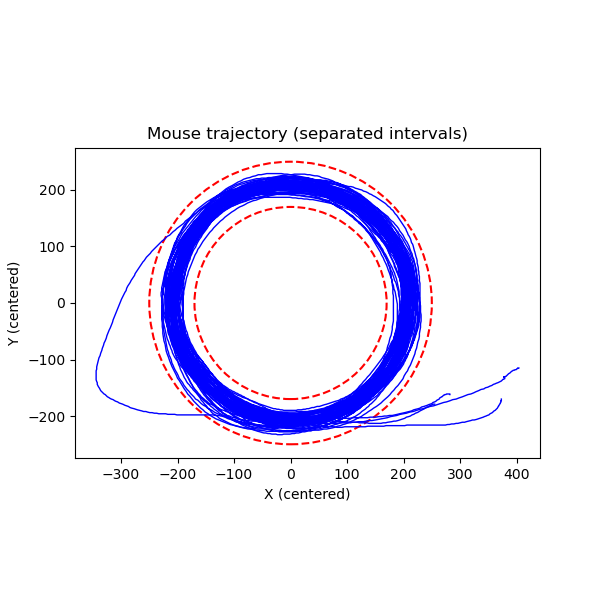

In [ ]:
# --- 1. Charger le CSV ---
data = np.loadtxt("data/001MoDe_R1.csv", delimiter=",", skiprows=4)
print(df.head())

csv_time = data[:,0]   # timestamps en ms UNIX
mouseX_raw = data[:,1]
mouseY_raw = data[:,2]
mouse_target = data[:,3]

# --- 2. Filtrer ---
filtered_mouseX = []
filtered_mouseY = []

for start_ms, end_ms, _ in intervals:

    # masque correct
    mask = (csv_time >= start_ms) & (csv_time <= end_ms)

    filtered_mouseX.extend(mouseX_raw[mask])
    filtered_mouseY.extend(mouseY_raw[mask])

mouseX = np.array(filtered_mouseX)
mouseY = np.array(filtered_mouseY)


#centerX 552;centerY 330
#Centrer les coordonnées de la souris
centerX = 552
centerY = 330
plt.figure(figsize=(6,6))
ax = plt.gca()   # <-- il manquait ça !

for start_ms, end_ms, _ in intervals:
    mask = (csv_time >= start_ms) & (csv_time <= end_ms)

    x_seg = mouseX_raw[mask] - centerX
    y_seg = -(mouseY_raw[mask] - centerY)  # inversion Y

    ax.plot(x_seg, y_seg, color='blue', linewidth=1)

# Cercles
external = plt.Circle((0, 0), 250, color='red', fill=False, linestyle='--', linewidth=1.5)
internal = plt.Circle((0, 0), 170, color='red', fill=False, linestyle='--', linewidth=1.5)

ax.add_patch(external)
ax.add_patch(internal)

ax.set_xlabel("X (centered)")
ax.set_ylabel("Y (centered)")
ax.set_title("Mouse trajectory (separated intervals)")

ax.set_aspect('equal', 'box')   # axes carrés

plt.show()
